In [1]:
#Deep learninig

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
df1 = pd.read_pickle('df_new.pkl')

In [43]:
#Gender,disease column to binry 
df1['Gender']=(df1['Gender'] == 'F').astype('int')
# these feature is if the patient have at least one of the disease we mark it as True (1)
df1['disease']=(df1['disease'] == True).astype('int')
df1=df1.rename(columns={'diff_day':'waiting_days'})

In [44]:
prior_total_missed=df1.groupby('PatientId')['Absent'].cumsum().to_frame().rename\
(columns={'Absent':'prior_total_missed'})
# join the prior total missed appointement to the dataset 
df1=df1.merge(prior_total_missed , left_index =True, right_index=True, how = "outer")   

In [45]:
# here i Want to know how many times the patient was before the current appointment,
#so every time he makes a new appointment, I will see how many times he has been before 
#the appointment and how many times he missed.
#
df1['Appointment']=1

In [46]:
total_prior_appoitments=df1.groupby('PatientId')['Appointment'].cumsum().to_frame().rename\
(columns={'Appointment':'prior_total_appointments'})
df1=df1.merge(total_prior_appoitments , left_index =True, right_index=True, how = "outer") 

In [47]:
col_todrop1=['PatientId','AppointmentID','ScheduledDay','AppointmentDay','Neighbourhood',\
            'DayName_AppointmentDay','DayName_schedualed','age_ranges','categor_wait','ScheduledDay_minute'\
           ,'sum_missed_appointment','Appointment','total_prior_appointments','disease','missed_appointment_before']

In [48]:
df=df1.drop(col_todrop1,axis=1).copy()
df.shape

(110516, 16)

In [49]:
y = df.Absent
X = df.drop('Absent', axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [52]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Define Custom Dataloaders


In [53]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

# Let’s initialize our dataloaders. We’ll use a batch_size = 1 for our test dataloader.

In [54]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

# Define Neural Net Architecture


In [60]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(15, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###################### OUTPUT ######################
cuda:0

cuda:0


In [61]:
model = LogisticRegression()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
###################### OUTPUT ######################



LogisticRegression(
  (layer_1): Linear(in_features=15, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# Train the model


In [62]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [70]:
model.train()
acc_dict={}
for e in range(1, EPOCHS+1):
    
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    acc_dict[e]=(epoch_acc/len(train_loader))

Epoch 001: | Loss: 0.09177 | Acc: 95.214
Epoch 002: | Loss: 0.09097 | Acc: 95.264
Epoch 003: | Loss: 0.09185 | Acc: 95.150
Epoch 004: | Loss: 0.09192 | Acc: 95.192
Epoch 005: | Loss: 0.09209 | Acc: 95.175
Epoch 006: | Loss: 0.09160 | Acc: 95.227
Epoch 007: | Loss: 0.09190 | Acc: 95.159
Epoch 008: | Loss: 0.09137 | Acc: 95.188
Epoch 009: | Loss: 0.09078 | Acc: 95.191
Epoch 010: | Loss: 0.09130 | Acc: 95.142
Epoch 011: | Loss: 0.09147 | Acc: 95.209
Epoch 012: | Loss: 0.09086 | Acc: 95.232
Epoch 013: | Loss: 0.09097 | Acc: 95.191
Epoch 014: | Loss: 0.09092 | Acc: 95.201
Epoch 015: | Loss: 0.09044 | Acc: 95.234
Epoch 016: | Loss: 0.09117 | Acc: 95.194
Epoch 017: | Loss: 0.09065 | Acc: 95.201
Epoch 018: | Loss: 0.09036 | Acc: 95.276
Epoch 019: | Loss: 0.09052 | Acc: 95.227
Epoch 020: | Loss: 0.09016 | Acc: 95.257
Epoch 021: | Loss: 0.09055 | Acc: 95.237
Epoch 022: | Loss: 0.09043 | Acc: 95.217
Epoch 023: | Loss: 0.09073 | Acc: 95.254
Epoch 024: | Loss: 0.09020 | Acc: 95.217
Epoch 025: | Los

In [71]:
acc_dict

{1: 95.21434745030251,
 2: 95.26447709593776,
 3: 95.15038893690578,
 4: 95.19187554019015,
 5: 95.17458945548833,
 6: 95.22731201382886,
 7: 95.1590319792567,
 8: 95.1875540190147,
 9: 95.19101123595506,
 10: 95.14174589455489,
 11: 95.20916162489196,
 12: 95.23163353500432,
 13: 95.19101123595506,
 14: 95.20138288677614,
 15: 95.23422644770959,
 16: 95.19360414866033,
 17: 95.20051858254105,
 18: 95.27571305099394,
 19: 95.22731201382886,
 20: 95.25669835782195,
 21: 95.23681936041487,
 22: 95.21694036300778,
 23: 95.25410544511668,
 24: 95.21694036300778,
 25: 95.28867761452031,
 26: 95.26879861711322,
 27: 95.19360414866033,
 28: 95.2618841832325,
 29: 95.28176318063959,
 30: 95.29991356957649,
 31: 95.19706136560069,
 32: 95.31719965427831,
 33: 95.32411408815904,
 34: 95.24632670700086,
 35: 95.35350043215212,
 36: 95.28694900605014,
 37: 95.29386343993086,
 38: 95.31114952463267,
 39: 95.28694900605014,
 40: 95.31114952463267,
 41: 95.2713915298185,
 42: 95.27052722558341,
 43: 

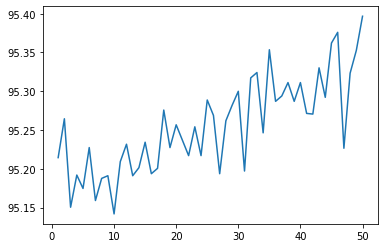

In [77]:
#plt.plot(*zip(*acc_dict.items()))
ax,fig=plt.subplots()
dates = list(acc_dict.keys())           # list() needed for python 3.x
prices = list(acc_dict.values())        # ditto
plt.plot(dates, prices, '-') 

In [64]:
# Test the model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [65]:
y_pred_list

[0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [66]:
confusion_matrix(y_test, y_pred_list)


array([[28360,   840],
       [ 1199,  6072]], dtype=int64)

In [67]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.96      0.97      0.97     29200
           1       0.88      0.84      0.86      7271

    accuracy                           0.94     36471
   macro avg       0.92      0.90      0.91     36471
weighted avg       0.94      0.94      0.94     36471

